In [1]:
# importing all required pakages and libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_squared_log_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest,mutual_info_regression
import xgboost
from sklearn.feature_selection import f_regression, GenericUnivariateSelect
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,KFold
from scipy.stats import zscore
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
sb.set()

In [2]:
ds = pd.read_excel('doc_fees_Train.xlsx')
ds

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250
...,...,...,...,...,...,...,...
5956,"MBBS, MS - ENT",19 years experience,98%,"Basavanagudi, Bangalore",ENT Specialist,"98% 45 Feedback Basavanagudi, Bangalore",300
5957,MBBS,33 years experience,NaN,"Nungambakkam, Chennai",General Medicine,NaN,100
5958,MBBS,41 years experience,97%,"Greater Kailash Part 2, Delhi",General Medicine,"97% 11 Feedback Greater Kailash Part 2, Delhi",600
5959,"MBBS, MD - General Medicine",15 years experience,90%,"Vileparle West, Mumbai",General Medicine,General Medical Consultation Viral Fever Treat...,100


### EDA and Data-preprocessing

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       5961 non-null   object
 1   Experience          5961 non-null   object
 2   Rating              2659 non-null   object
 3   Place               5936 non-null   object
 4   Profile             5961 non-null   object
 5   Miscellaneous_Info  3341 non-null   object
 6   Fees                5961 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 326.1+ KB


In [4]:
ds.isnull().sum()

Qualification            0
Experience               0
Rating                3302
Place                   25
Profile                  0
Miscellaneous_Info    2620
Fees                     0
dtype: int64

From above series, we have missing values to impute.

In [5]:
for col in ds.columns:
    print(col, ds[col].value_counts().count())

Qualification 1420
Experience 64
Rating 51
Place 877
Profile 6
Miscellaneous_Info 2998
Fees 40


In [6]:
# imputing missing values of column 'Place'
ds['Place'] = ds.groupby(['Profile'])['Place'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [7]:
# imputing missing values of column 'Rating'
ds['Rating'] = ds.groupby(['Profile'])['Rating'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [8]:
# imputing missing values of column 'Miscellaneous_Info'
ds['Miscellaneous_Info'] = ds.groupby(['Profile'
                  ]).transform(lambda x:
                                x.fillna(x.mode()[0]))

In [9]:
# splitting column 'Qualification' into 'Qualification' and 'specialization'
ds[['Qualification','specialization']] = ds.Qualification.str.split(",",expand=True).iloc[:,0:2]

In [10]:
# imputing missing values of column 'specialization'
ds['specialization'] = ds.groupby(['Profile',
                    ])['specialization'].transform(lambda x:
                                x.fillna(x.mode()[0]))

In [11]:
# splitting 'Place' column into 'local_area' and 'city'
ds[['local_area','city']] = ds.Place.str.split(",",expand=True).iloc[:,0:2]

In [12]:
# imputing missing values of column 'city'
ds['city'].fillna(ds['city'].mode()[0],inplace = True)

In [13]:
# removing '%' sign from Rating and converting dtype to numeric
ds['Rating'] = ds.Rating.str.strip('%').astype('float64')

In [14]:
# removing string '  years experience' from column 'Experience'  and converting dtype to numeric
ds['Experience'] = ds.Experience.str.strip(' years experience').astype('float64')

In [15]:
ds

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,specialization,local_area,city
0,BHMS,24.0,100.0,"Kakkanad, Ernakulam",Homeopath,"BHMS, MD - Homeopathy",100,MD - Homeopathy,Kakkanad,Ernakulam
1,BAMS,12.0,98.0,"Whitefield, Bangalore",Ayurveda,"BAMS, MD - Ayurveda Medicine",350,MD - Ayurveda Medicine,Whitefield,Bangalore
2,MBBS,9.0,100.0,"Mathikere - BEL, Bangalore",ENT Specialist,"MBBS, MS - Otorhinolaryngology",300,MS - Otorhinolaryngology,Mathikere - BEL,Bangalore
3,BSc - Zoology,12.0,100.0,"Bannerghatta Road, Bangalore",Ayurveda,"BSc - Zoology, BAMS",250,BAMS,Bannerghatta Road,Bangalore
4,BAMS,20.0,100.0,"Keelkattalai, Chennai",Ayurveda,BAMS,250,MD - Ayurveda Medicine,Keelkattalai,Chennai
...,...,...,...,...,...,...,...,...,...,...
5956,MBBS,19.0,98.0,"Basavanagudi, Bangalore",ENT Specialist,"MBBS, MS - ENT",300,MS - ENT,Basavanagudi,Bangalore
5957,MBBS,33.0,100.0,"Nungambakkam, Chennai",General Medicine,MBBS,100,MD - General Medicine,Nungambakkam,Chennai
5958,MBBS,41.0,97.0,"Greater Kailash Part 2, Delhi",General Medicine,MBBS,600,MD - General Medicine,Greater Kailash Part 2,Delhi
5959,MBBS,15.0,90.0,"Vileparle West, Mumbai",General Medicine,"MBBS, MD - General Medicine",100,MD - General Medicine,Vileparle West,Mumbai


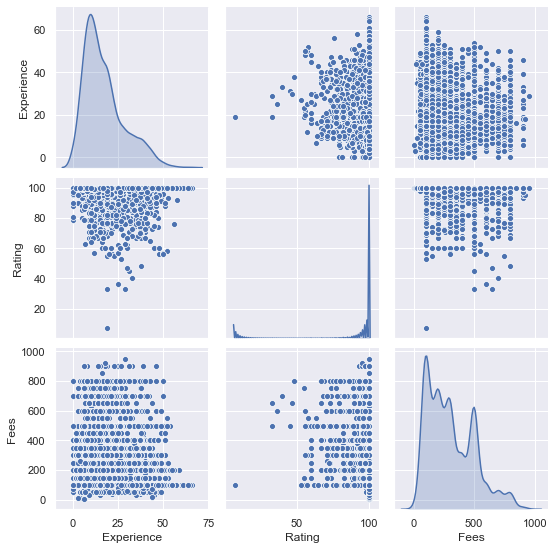

In [16]:
sb.pairplot(ds[['Experience','Rating','Fees']], diag_kind = 'kde' )

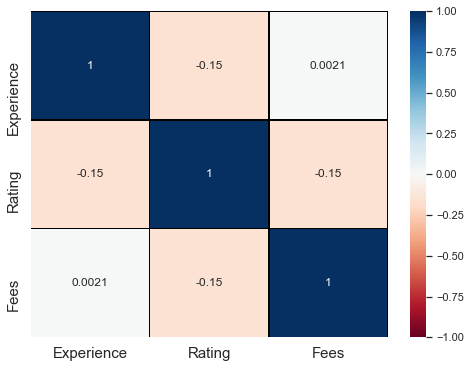

In [17]:
plt.figure(figsize = (8,6))
sb.heatmap(ds[['Experience','Rating','Fees']].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above pairplot and heatmap, we don't any direct relations or correlations among variables.
Also, Rating column is highly left skewed.

In [18]:
for col in  list(ds.select_dtypes(include = 'O')):
    print(col,'\n', ds[col].value_counts())
    print('--------------------------------------------')  

Qualification 
 MBBS                                  2448
BDS                                   1208
BAMS                                   711
BHMS                                   706
MD - Dermatology                        84
                                      ... 
MRCGP                                    1
FRGUHS                                   1
Fellowship In Clinical Cosmetology       1
Diploma in Skin & Vinereal Disease       1
39 years experience                      1
Name: Qualification, Length: 151, dtype: int64
--------------------------------------------
Place 
 Banjara Hills, Hyderabad         89
HSR Layout, Bangalore            75
Andheri West, Mumbai             70
Dwarka, Delhi                    67
Mulund West, Mumbai              54
                                 ..
Uday Park, Delhi                  1
Manjapra, Ernakulam               1
Poovachal, Thiruvananthapuram     1
Jahangirpuri, Delhi               1
TV Museum, Thiruvananthapuram     1
Name: Place, Le

From above series data, we see lot of columns categories are having only one unique values, which is not usefull for modelling, so we shall group them into separate group. 

In [19]:
# grouping categories having unique values less then then 5 into 'other' group.
for col in  list(ds.select_dtypes(include = 'O')):
    group = list(ds[col].value_counts()[ds[col].value_counts() < 5].index)
    ds[col] = ds[col].apply(lambda x :'Other' if x in group 
                                     else x)

In [20]:
for col in  list(ds.select_dtypes(include = 'O')):
    print(col,'\n', ds[col].value_counts())
    print('--------------------------------------------')  

Qualification 
 MBBS                                                     2448
BDS                                                      1208
BAMS                                                      711
BHMS                                                      706
Other                                                     144
MD - Dermatology                                           84
MS - ENT                                                   71
MD - Dermatology                                           62
MD - Homeopathy                                            56
MD - Ayurveda Medicine                                     38
DHMS (Diploma in Homeopathic Medicine and Surgery)         36
MDS - Oral & Maxillofacial Surgery                         26
MD - General Medicine                                      26
MDS - Conservative Dentistry & Endodontics                 25
MS - Otorhinolaryngology                                   25
Get inspired by remarkable stories of people like you 

In [21]:
# Here, we are trying to tune the smoothing parameter using cross validation on training-set.
# this is usually done to prevent the mean/target encoded data to overfit the training set. 

x_train, x_test, y_train, y_test = train_test_split(ds.drop(['Fees'], 1), 
                                                    ds.Fees,
                                                test_size = 0.30, random_state = 42) 
score_list = []
smoothing_list = np.arange(0,5,.125)
model  =  RandomForestRegressor() # using RandomForestRegressor model for tuning smoothing parameter.
for num in smoothing_list:
    x_train_en = x_train.copy()
    
    for col in list(ds.select_dtypes(include = 'O')):
        

        encoder =  ce.TargetEncoder(cols = col, smoothing = num)
        x_train_en[col] = encoder.fit_transform(x_train_en[col], y_train)
    score = cross_val_score(model, x_train_en, y_train, cv = 10, scoring = 'r2', n_jobs = -1 ).mean()
    score_list.append(score)
        
print('Optimum cross-val-score:',max(score_list),
      'corresponds to smoothing value of:',smoothing_list[score_list.index(max(score_list))])    

Optimum cross-val-score: 0.2909066261605612 corresponds to smoothing value of: 3.375


In [22]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['Fees'], 1), 
                                                    ds.Fees,
                                                test_size = 0.30, random_state = 42) 


In [23]:
x_train_copy = x_train.copy() # copying x_train for later on.

In [24]:
# target encoding features  using tuned smoothing value.
for col in list(ds.select_dtypes(include = 'O')):
    if col not in ['Profile','city']:
    
        encoder =  ce.TargetEncoder(cols = col, smoothing =   4.25)
        x_train[col] = encoder.fit_transform(x_train[col], y_train)
        x_test[col] = encoder.transform(x_test[col])

In [25]:
# dummy encoding  columns 'Profile' and 'city'
x_train = pd.get_dummies(data = x_train, prefix =  ['Profile','city'], columns =  ['Profile','city'], drop_first = True)
x_test = pd.get_dummies(data = x_test, prefix =  ['Profile','city'], columns =  ['Profile','city'], drop_first = True)

In [26]:
#  robust-scaling features 'Rating' and 'Experience'
for col in ['Rating','Experience']:
    
    scaler = RobustScaler()
    x_train[col] = scaler.fit_transform(x_train[col].values.reshape(-1,1))
    x_test[col] = scaler.transform(x_test[col].values.reshape(-1,1))

In [27]:
x_train

,Qualification,Experience,Rating,Place,Miscellaneous_Info,specialization,local_area,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath,city_ Chennai,city_ Coimbatore,city_ Delhi,city_ Ernakulam,city_ Hyderabad,city_ Mumbai,city_ Thiruvananthapuram,city_Other
5099,358.687500,1.714286,0.0,186.071716,275.517291,306.148148,186.071716,0,0,1,0,0,1,0,0,0,0,0,0,0
5429,325.480769,-0.571429,0.0,267.932277,334.098655,373.013699,267.797965,0,0,0,1,0,0,0,0,0,1,0,0,0
257,358.687500,1.214286,0.0,348.816334,365.817814,385.000000,348.816334,0,0,1,0,0,0,0,0,0,0,1,0,0
507,358.687500,-0.785714,0.0,403.557093,392.391304,390.909091,403.557093,0,1,0,0,0,0,0,0,0,1,0,0,0
1893,307.317025,-0.357143,-0.5,398.436520,334.098655,354.541914,398.436520,0,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,239.059977,-0.357143,-1.5,299.268291,200.190058,212.585837,299.268291,1,0,0,0,0,0,0,0,0,0,0,0,0
5191,358.687500,-0.357143,0.0,201.379832,397.619006,412.195121,201.379832,0,1,0,0,0,0,0,0,1,0,0,0,0
5226,358.687500,1.714286,0.0,307.398746,334.098655,312.659574,307.398746,0,0,0,1,0,0,0,0,0,0,0,0,0
5390,239.059977,0.142857,-1.0,333.908965,216.325001,220.810287,333.908965,1,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# droping feature that occurs only once.
x_train.drop('city_Other', 1, inplace = True)

In [29]:
# feature selction using selectkbest
selector = SelectKBest(mutual_info_regression)
selector.fit(x_train, y_train)

SelectKBest(score_func=<function mutual_info_regression at 0x000002B724899558>)

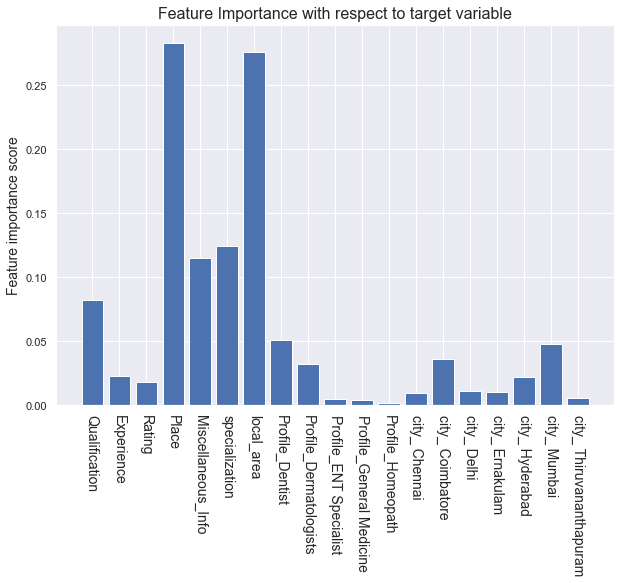

In [30]:
# plotting  the scores
plt.figure(figsize = (10,7))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 14)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)
plt.show()

Here we see that, place and local area are most important factors, followed by specialization, miscellaneous_info and qualification, for determinating  doctors fees.

In [31]:
selector = pd.DataFrame(dict(Feature = list(x_train.columns), Scores = selector.scores_))
selector.sort_values(by = 'Scores', ascending = False ).head(30)

,Feature,Scores
3,Place,0.283471
6,local_area,0.275825
5,specialization,0.124768
4,Miscellaneous_Info,0.115004
0,Qualification,0.081968
7,Profile_Dentist,0.050840
17,city_ Mumbai,0.047450
13,city_ Coimbatore,0.035898
8,Profile_Dermatologists,0.032139
1,Experience,0.022524


In [32]:
# keeping features with scores above threshold score.
threshold = 0
selected_features = selector[selector.Scores > threshold]
selected_features.sort_values(by = 'Scores', ascending = False )

,Feature,Scores
3,Place,0.283471
6,local_area,0.275825
5,specialization,0.124768
4,Miscellaneous_Info,0.115004
0,Qualification,0.081968
7,Profile_Dentist,0.050840
17,city_ Mumbai,0.047450
13,city_ Coimbatore,0.035898
8,Profile_Dermatologists,0.032139
1,Experience,0.022524


In [33]:
print('no. of selected features:', len(selected_features))

no. of selected features: 19


In [34]:
# selecting highest scoring features for train and test set.
x_train_red = x_train[list(selected_features['Feature'])]
x_test_red = x_test[list(selected_features['Feature'])]

In [35]:
x_train_red.shape, x_test_red.shape

((4172, 19), (1789, 19))

In [36]:
x_test_red

,Qualification,Experience,Rating,Place,Miscellaneous_Info,specialization,local_area,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath,city_ Chennai,city_ Coimbatore,city_ Delhi,city_ Ernakulam,city_ Hyderabad,city_ Mumbai,city_ Thiruvananthapuram
1344,239.059977,-0.571429,0.0,321.487432,200.190058,212.585837,321.487432,1,0,0,0,0,0,0,0,0,0,0,0
625,293.874064,0.500000,0.0,201.664024,334.098655,212.585837,201.664024,1,0,0,0,0,1,0,0,0,0,0,0
5909,358.687500,-0.285714,-3.0,384.807476,419.455818,413.683676,384.807476,0,0,0,1,0,0,0,0,0,0,0,0
3560,358.687500,0.714286,0.0,360.899927,393.783784,385.000000,360.899927,0,0,1,0,0,0,0,0,0,0,0,0
1545,307.317025,-0.071429,0.0,321.492527,334.098655,312.659574,321.492527,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,239.059977,-0.642857,0.0,216.971817,200.190058,212.585837,216.971817,1,0,0,0,0,0,0,0,0,1,0,0
5781,358.687500,-0.071429,-1.5,340.206884,334.098655,377.941423,340.206884,0,0,0,1,0,0,0,1,0,0,0,0
5670,201.793463,-0.142857,0.0,238.298536,334.098655,212.585837,238.298536,1,0,0,0,0,1,0,0,0,0,0,0
4051,235.986166,-0.428571,0.0,293.965539,291.875006,227.883610,293.965539,0,0,0,0,0,0,0,0,0,1,0,0


In [37]:
k =  KFold(n_splits = 10)

### Base Model Evaluation

model: RandomForestRegressor()
CV score:0.28367157701413237
score_std: 0.03744791258802699
----------
model: LinearRegression(normalize=True)
CV score:0.299091545795391
score_std: 0.034252001617492873
----------
model: SVR()
CV score:0.2193539469612083
score_std: 0.026983650880232992
----------
model: AdaBoostRegressor()
CV score:0.24557879377188527
score_std: 0.021901097964713668
----------
model: GradientBoostingRegressor()
CV score:0.30539363953457765
score_std: 0.03368429164993724
----------
model: KNeighborsRegressor()
CV score:0.19348825413291387
score_std: 0.060464583512835825
----------
model: XGBRegressor(silent=True)
CV score:0.3047598491994246
score_std: 0.03443060757135191
----------
model: Lasso(normalize=True)
CV score:0.1145551091607582
score_std: 0.012320689343168528
----------
model: Ridge(normalize=True)
CV score:0.27779299860658835
score_std: 0.02439815801044128
----------
model: ElasticNet()
CV score:0.2980583662704587
score_std: 0.03418175926633774
----------
model

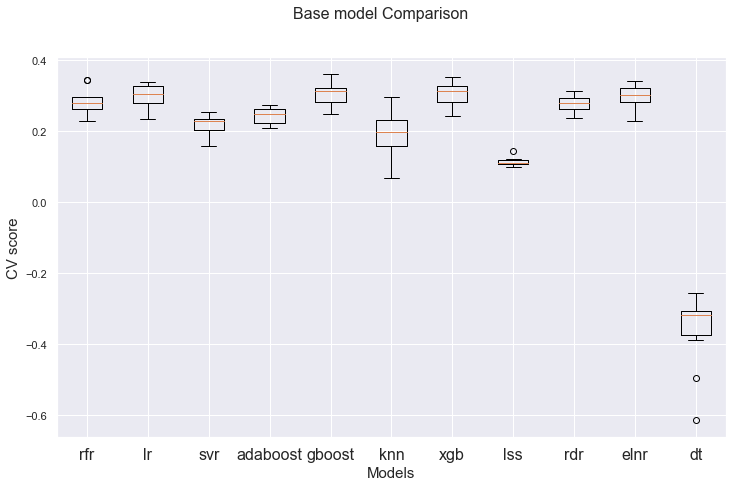

In [38]:
# inilializing different models
rfr = RandomForestRegressor()
svr = SVR()
lr = LinearRegression(normalize = True)
adaboost =  AdaBoostRegressor()
gboost = GradientBoostingRegressor()
knn = KNeighborsRegressor()
xgb = xgboost.XGBRegressor(silent = True)
lss = Lasso(normalize = True)
rdr = Ridge(normalize = True)
elnr = ElasticNet()
dt = DecisionTreeRegressor()

models = [rfr, lr, svr, adaboost, gboost, knn, xgb, lss, rdr, elnr, dt]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train_red, y_train, cv = k, scoring = 'r2', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rfr', 'lr','svr', 'adaboost', 'gboost', 'knn', 'xgb','lss','rdr','elnr','dt'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('CV score', fontsize = 15)
fig.set_size_inches(12,7)
plt.show() 

Based on above cross-val-score, we shall choose models like- rfr, lr, gboost, xgb, rdr and elnr for further tuning.

### Hyper-parameter tuning

In [39]:
# initializing parameters for each models for model-tuning.
param_gboost =  dict(
    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5],
    max_depth = [ 2,3, 4, 5, 6,7, 8],
    n_estimators = [100, 150, 200,250,300],
    min_samples_split = [1,2,3], random_state = [40,41,42,43,44],
    alpha = [0.05,0.1,0.5,0.75,1,1.75,2])

param_rfr = dict(n_estimators = [10,15,20,25,30], criterion = ['mse', 'mae'],
                max_depth = [3,4,5,6,7,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [40,41,42,43,44])

  
param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ],
     alpha = [0.05,0.1,0.5,0.75,1,1.75,2]
     )

param_elnr = dict(alpha = np.arange(0.05,2, 0.05), l1_ratio = np.arange(0.05,1, 0.01),
                 normalize = [True, False], selection = ['cyclic', 'random'])

param_rdr = dict(alpha = np.arange(0.05,2, 0.05), solver = ['svd', 
         'cholesky','lsqr','sparse_cg','sag','saga'])

In [40]:
model_param_list = [(gboost,param_gboost),(rfr,param_rfr), (xgb,param_xgb), (rdr ,param_rdr), (elnr,param_elnr)]

In [41]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_rearch = RandomizedSearchCV(model, param, cv = k, n_jobs = -1, scoring = 'neg_root_mean_squared_error',
                                  random_state = 42)
    r_rearch.fit( x_train_red, y_train.values.ravel())
    best_cvscore = r_rearch.best_score_
    best_param = r_rearch.best_params_
    best_estimator = r_rearch.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingRegressor()
best_cvscore: -159.18176688060356
best_param: {'random_state': 44, 'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.05, 'alpha': 0.75}


model: RandomForestRegressor()
best_cvscore: -159.15074697995655
best_param: {'random_state': 40, 'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'mse'}


model: XGBRegressor(silent=True)
best_cvscore: -159.12267272376593
best_param: {'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.4, 'alpha': 0.1}


model: Ridge(normalize=True)
best_cvscore: -160.61049239455335
best_param: {'solver': 'sparse_cg', 'alpha': 0.1}


model: ElasticNet()
best_cvscore: -160.6257920591834
best_param: {'selection': 'cyclic', 'normalize': False, 'l1_ratio': 0.26000000000000006, 'alpha': 0.1}


best_estimators: [GradientBoostingRegressor(alpha=0.75, learning_rate=0.05, max_depth=5,
                          n_estimat

### Testing

In [42]:
best_estimator_list.append(lr) # appending linear regression for testing.

In [43]:
# testing for train data
print('****TRAIN RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_train_red)
    score = r2_score(y_train, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_train, y_pred, squared = False))
    print('-------------------------------------------')

****TRAIN RESULTS****


model GradientBoostingRegressor(alpha=0.75, learning_rate=0.05, max_depth=5,
                          n_estimators=150, random_state=44)
accuracy (r2_score): 48.09 %
root_mean_squared_error: 138.4116779264563
-------------------------------------------
model RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=30, random_state=40)
accuracy (r2_score): 43.98 %
root_mean_squared_error: 143.7918404174674
-------------------------------------------
model XGBRegressor(alpha=0.1, colsample_bytree=0.4, gamma=0.3, learning_rate=0.05,
             max_depth=6, min_child_weight=5, silent=True)
accuracy (r2_score): 47.59 %
root_mean_squared_error: 139.07321653723452
-------------------------------------------
model Ridge(alpha=0.1, normalize=True, solver='sparse_cg')
accuracy (r2_score): 30.55 %
root_mean_squared_error: 160.09208275410631
-------------------------------------------
model ElasticNet(alpha=0.1, l1_ra

In [44]:
# testing for test data
print('****TEST RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_test_red)
    score = r2_score(y_test, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_test, y_pred, squared = False))
    print('-------------------------------------------')

****TEST RESULTS****


model GradientBoostingRegressor(alpha=0.75, learning_rate=0.05, max_depth=5,
                          n_estimators=150, random_state=44)
accuracy (r2_score): 25.26 %
root_mean_squared_error: 162.5780401778358
-------------------------------------------
model RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=30, random_state=40)
accuracy (r2_score): 25.35 %
root_mean_squared_error: 162.48485436356313
-------------------------------------------
model XGBRegressor(alpha=0.1, colsample_bytree=0.4, gamma=0.3, learning_rate=0.05,
             max_depth=6, min_child_weight=5, silent=True)
accuracy (r2_score): 26.39 %
root_mean_squared_error: 161.34338154176515
-------------------------------------------
model Ridge(alpha=0.1, normalize=True, solver='sparse_cg')
accuracy (r2_score): 23.0 %
root_mean_squared_error: 165.0228480430566
-------------------------------------------
model ElasticNet(alpha=0.1, l1_rati

From above train and test results, XGBRegressor has the best r2 score and lowest root mean sqaured error, compared to other models. Therefore, we shall choose it as our regression model for this project.

In [45]:
selected_model = RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=30, random_state=40)
selected_model.fit(x_train_red, y_train)


y_pred = selected_model.predict(x_test_red)

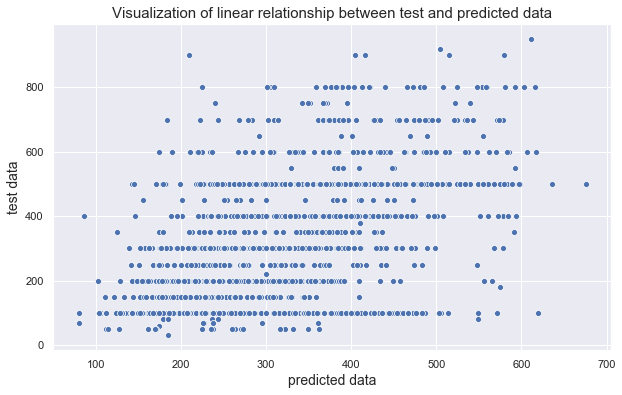

In [46]:
plt.figure(figsize = (10,6))
sb.scatterplot(y_pred,y_test )
plt.xlabel('predicted data', fontsize = 14)
plt.ylabel('test data',  fontsize = 14)
plt.title('Visualization of linear relationship between test and predicted data',fontsize = 15 )
plt.show()

From above scatter plot, although the points are scattered widely, but there appears to have certain relationship between the variables.

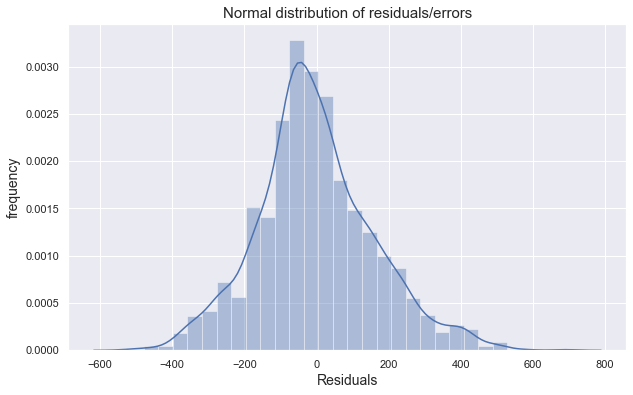

In [47]:
plt.figure(figsize = (10,6))
sb.distplot((y_test-y_pred), bins = 30)
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('frequency',  fontsize = 14)
plt.title('Normal distribution of residuals/errors',fontsize = 15 )
plt.show()

From above distplot plot, we can see that residuals from our model are almost normally distributed with approximately zero mean.

In [48]:
test_df = pd.DataFrame({'Actual fees':y_test.values,'Predicted fees':y_pred})

In [49]:
test_df.to_csv('doc_fees_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [50]:
# Saving the final model as XGBRegressor.
import joblib

joblib.dump(selected_model, 'doc_fees_pred.obj')
print('Model successfully saved.')

Model successfully saved.


### Data-preprocessing and prediction of Test dataset

In [51]:
test = pd.read_excel('doc_fees_Test.xlsx')
test

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...
...,...,...,...,...,...,...
1982,"BAMS, Doctor of Medicine",10 years experience,NaN,"Basavanagudi, Bangalore",Ayurveda,NaN
1983,"MD - Dermatology , Venereology & Leprosy, MBBS",4 years experience,NaN,"Choolai, Chennai",Dermatologists,NaN
1984,"MBBS, MD / MS - Obstetrics & Gynaecology",9 years experience,NaN,"Porur, Chennai",General Medicine,NaN
1985,BDS,12 years experience,98%,"Arekere, Bangalore",Dentist,RCT - Root Canal Treatment Root Canal Treatmen...


In [52]:
test.isnull().sum()

Qualification            0
Experience               0
Rating                1090
Place                    6
Profile                  0
Miscellaneous_Info     834
dtype: int64

In [53]:
# imputing missing values of column 'Place'
test['Place'] = test.groupby(['Profile'])['Place'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [54]:
# imputing missing values of column 'Rating'
test['Rating'] = test.groupby(['Profile'])['Rating'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [55]:
# imputing missing values of column 'Miscellaneous_Info'
test['Miscellaneous_Info'] = test.groupby(['Profile'
                  ]).transform(lambda x:
                                x.fillna(x.mode()[0]))

In [56]:
# splitting column 'Qualification' into 'Qualification' and 'specialization'
test[['Qualification','specialization']] = test.Qualification.str.split(",",expand=True).iloc[:,0:2]

In [57]:
# imputing missing values of column 'specialization'
test['specialization'] = test.groupby(['Profile',
                    ])['specialization'].transform(lambda x:
                                x.fillna(x.mode()[0]))

In [58]:
# splitting 'Place' column into 'local_area' and 'city'
test[['local_area','city']] = test.Place.str.split(",",expand=True).iloc[:,0:2]

In [59]:
# imputing missing values of column 'city'
test['city'].fillna(ds['city'].mode()[0],inplace = True)

In [60]:
# removing '%' sign from Rating and converting dtype to numeric
test['Rating'] = test.Rating.str.strip('%').astype('float64')

In [61]:
# removing string '  years experience' from column 'Experience'  and converting dtype to numeric
test['Experience'] = test.Experience.str.strip(' years experience').astype('float64')

In [62]:
# grouping categories having unique values less then  5 into 'other' group.
for col in  list(test.select_dtypes(include = 'O')):
    group = list(test[col].value_counts()[test[col].value_counts() < 5].index)
    test[col] = test[col].apply(lambda x :'Other' if x in group 
                                     else x)

In [63]:
# target encoding features  using tuned smoothing value.
for col in list(ds.select_dtypes(include = 'O')):
    if col not in ['Profile','city']:
    
        encoder =  ce.TargetEncoder(cols = col, smoothing =   4.25)
        x_train_copy[col] = encoder.fit_transform(x_train_copy[col], y_train)
        test[col] = encoder.transform(test[col])

In [64]:
# dummy encoding  columns 'Profile' and 'city'
x_train_copy = pd.get_dummies(data = x_train_copy, prefix =  ['Profile','city'], columns =  ['Profile','city'], drop_first = True)
test = pd.get_dummies(data = test, prefix =  ['Profile','city'], columns =  ['Profile','city'], drop_first = True)

In [65]:
#  robust-scaling features 'Rating' and 'Experience'
for col in ['Rating','Experience']:
    
    scaler = RobustScaler()
    x_train_copy[col] = scaler.fit_transform(x_train_copy[col].values.reshape(-1,1))
    test[col] = scaler.transform(test[col].values.reshape(-1,1))

In [66]:
# feature selecting for test dataset.
test = test[list(selected_features['Feature'])]

In [67]:
test

,Qualification,Experience,Rating,Place,Miscellaneous_Info,specialization,local_area,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath,city_ Chennai,city_ Coimbatore,city_ Delhi,city_ Ernakulam,city_ Hyderabad,city_ Mumbai,city_ Thiruvananthapuram
0,358.687500,1.428571,0.0,362.541485,233.811659,282.678571,362.541485,0,0,0,1,0,0,0,0,0,0,1,0
1,358.687500,1.142857,0.0,267.932277,275.517291,306.148148,267.797965,0,0,1,0,0,0,0,0,0,1,0,0
2,358.687500,1.785714,-15.0,267.932277,397.619006,412.195121,267.797965,0,1,0,0,0,1,0,0,0,0,0,0
3,235.986166,-1.071429,0.0,267.932277,213.654867,227.883610,267.797965,0,0,0,0,0,0,0,1,0,0,0,0
4,239.059977,0.071429,0.0,267.932277,260.204682,270.339028,267.797965,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982,235.986166,-0.357143,0.0,267.932277,334.098655,312.659574,267.797965,0,0,0,0,0,0,0,0,0,0,0,0
1983,406.034337,-0.785714,-1.0,267.932277,406.918337,397.656217,267.797965,0,1,0,0,0,1,0,0,0,0,0,0
1984,358.687500,-0.428571,0.0,267.932277,334.098655,312.659574,267.797965,0,0,0,1,0,1,0,0,0,0,0,0
1985,239.059977,-0.214286,-1.0,267.932277,200.190058,212.585837,267.797965,1,0,0,0,0,0,0,0,0,0,0,0


In [68]:
# loading model object file for prediction of test dataset.
model = joblib.load('doc_fees_pred.obj')

In [69]:
y_test_pred = model.predict(test)

In [70]:
test_2 = pd.DataFrame({'Pedicted fees':y_test_pred})

In [71]:
test_2.to_csv('doc_fees_test_pred.csv', index = False)
print('Predicted result of test data  stored sucessfully.')

Predicted result of test data  stored sucessfully.
